<a href="https://colab.research.google.com/github/climate-and-health-datasci-Unicamp/py-climate-health-toolbox/blob/master/examples/Comparison_IAC_VCP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Comparison of Heatwave Metrics between IAC and VCP weather stations - Campinas**

The present report conducts a comparison between heatwave metrics of two weather stations from Campinas: the IAC’s weather station (Agronomic Institute of Campinas) and the weather station located in the Viracopos Airport (VCP) with recorded data since 1983.

--------------------------------------------------------------------------------


*Daniela Souza de Oliveira*¹, *Luiza Marchezan Bezerra*², *Paula Dornhofer Paro Costa*​¹, *Ana Maria Heuminski de Avila*²​, *Eliana Cotta de Faria​*³

¹ Depto. de Eng. de Computação e Automação Industrial, Faculdade de Engenharia Elétrica e de Computação, Universidade Estadual de Campinas (Unicamp)

² Centro de Pesquisas Meteorológicas e Climáticas Aplicadas à Agricultura, CEPAGRI

³ Depto. de Patologia Clínica, Faculdade de Ciências Médicas (FCM), Universidade Estadual de Campinas (Unicamp)

*July, 2020*

--------------------------------------------------------------------------------
**Input files:** *IAC_HW1956_2018.csv*, *Viracopos_1983_2018.csv* and *IAC_pct1956_2018.csv*

**Summary:**

*  Applying linear regression to obtain a climatological normal for VCP (1961-1990)
*  Computing heatwaves for VCP weather station
*  Computing Yearly and Seasonal Metrics
*  Comparison between IAC and VCP
      > Coincident heatwave days

      > Tmax, Tmin and percentiles plot (Out. 2014 - Fev. 2015)



**Output:** Dataframes VCP_climaticNormal (*VCP_nc_6190.csv*), HW_VCP_metrics and HW_VCP_seasonMetrics

### Installing packages and importing libraries

In [ ]:
#installing packages
!pip install py-climate-health-toolbox

In [ ]:
!pip install --upgrade google-cloud

In [ ]:
#importing libraries
import pandas as pd
import numpy as np
import climahe.climatex
import climatex as tex
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.impute import SimpleImputer

In [ ]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

#Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

### Loading Data:

*   IAC: *IAC_HW1956_2018.csv* - IAC database including heatwaves information

*   VCP: *Viracopos_1983_2018.csv* - VCP database already cleaned


#### IAC

In [ ]:
#Loading IAC data
googl = drive.CreateFile({'id':'1k_BcMuR2ALY0p-EuzJ_hWMB4lyurEpX4'})
googl.GetContentFile('IAC_HW1956_2018.csv')

In [ ]:
#Reading data
IAC = pd.read_csv('/content/IAC_HW1956_2018.csv')

#converting column 'DATE' to datetime format
IAC['DATE'] = pd.to_datetime(IAC['DATE'])

del IAC['Unnamed: 0']
IAC

,DAY365,DATE,YEAR,N_RAIN_TOT,N_AIRTMP_MAX,N_AIRTMP_MIN,above_pct,HW
0,1,1956-01-01,1956,5.5,30.3,18.8,0,0
1,2,1956-01-02,1956,6.6,31.1,19.4,0,0
2,3,1956-01-03,1956,13.8,33.1,19.9,0,0
3,4,1956-01-04,1956,0.0,31.7,20.1,0,0
4,5,1956-01-05,1956,0.7,32.7,19.1,0,0
...,...,...,...,...,...,...,...,...
22990,361,2018-12-27,2018,0.0,28.8,19.0,0,0
22991,362,2018-12-28,2018,23.1,31.2,18.6,0,0
22992,363,2018-12-29,2018,0.0,31.7,18.7,0,0
22993,364,2018-12-30,2018,0.0,32.1,19.8,0,0


##### Selecting IAC data from the same period as VCP data

In [ ]:
df_IAC = IAC[(IAC['YEAR']>=1983)&(IAC['YEAR']<=2018)] #defining database
df_IAC = df_IAC.reset_index()
del df_IAC['index']

df_IAC.head(2)

,DAY365,DATE,YEAR,N_RAIN_TOT,N_AIRTMP_MAX,N_AIRTMP_MIN,above_pct,HW
0,1,1983-01-01,1983,5.2,28.8,17.5,0,0
1,2,1983-01-02,1983,0.0,29.4,17.2,0,0


##### Selecting climatological normal 1961-1990

In [ ]:
IAC_climaticNormal = IAC[(IAC['YEAR']>1960)&(IAC['YEAR']<=1990)] #defining climatic normal
IAC_climaticNormal = IAC_climaticNormal.reset_index()
del IAC_climaticNormal['index']

IAC_climaticNormal.head(2)

,DAY365,DATE,YEAR,N_RAIN_TOT,N_AIRTMP_MAX,N_AIRTMP_MIN,above_pct,HW
0,1,1961-01-01,1961,0.3,27.9,19.0,0,0
1,2,1961-01-02,1961,27.4,26.0,19.1,0,0


#### VCP

In [ ]:
#Loading VCP data
g = drive.CreateFile({'id':'1-TtdAsK0L9pE8MsZgd_IgpXNyDhJHh7J'})
g.GetContentFile('Viracopos_1983_2018.csv')

In [ ]:
#Reading data
df_VCP = pd.read_csv('/content/Viracopos_1983_2018.csv')
del df_VCP['Unnamed: 0']

#converting column 'DATE' to datetime format
df_VCP['DATE'] = pd.to_datetime(df_VCP['DATE'])

df_VCP

,DATE,N_AIRTMP_MAX,N_AIRTMP_MIN
0,1983-01-01,30.0,18.0
1,1983-01-02,29.3,18.0
2,1983-01-03,30.6,18.6
3,1983-01-04,30.5,19.0
4,1983-01-05,22.0,19.4
...,...,...,...
12864,2018-12-27,31.2,18.4
12865,2018-12-28,31.5,18.9
12866,2018-12-29,32.1,18.7
12867,2018-12-30,33.6,19.4


#### Completing missing DATES on both dataframes

Function: *tex.complete_df* from climatex library

In [ ]:
help(tex.complete_df)

Help on function complete_df in module climatex:

complete_df(df)
    #-------------------------------------------------------------------------------
    ## Function to add missing DATES in a dataframe. This is done in order to fill
    ## the dates of all years contained in the dataframe
    ## 
    ## ATTENTION The column DATE of the dataframe needs to be converted to
    ## pandas.datetime and needs to be called DATE
    ## 
    ## :param      df:   Dataframe containing the database with column DATE
    ## :type       df:   pandas.DataFrame
    ##
    ## :returns:   df Completed dataframe
    ## :rtype:     pandas.DataFrame
    ##



In [ ]:
#completing missing DATES on IAC dataframe
df_IAC=tex.complete_df(df_IAC)

df_IAC.head(2)

,DATE,DAY365,YEAR,N_RAIN_TOT,N_AIRTMP_MAX,N_AIRTMP_MIN,above_pct,HW
0,1983-01-01,1.0,1983.0,5.2,28.8,17.5,0.0,0.0
1,1983-01-02,2.0,1983.0,0.0,29.4,17.2,0.0,0.0


In [ ]:
#completing missing DATES on VCP dataframe
df_VCP=tex.complete_df(df_VCP)

df_VCP.head(2)

,DATE,N_AIRTMP_MAX,N_AIRTMP_MIN
0,1983-01-01,30.0,18.0
1,1983-01-02,29.3,18.0


## **Plot IAC vs. VCP** 

### Maximum temperatures

Text(0.5, 1.0, 'IAC x VCP')

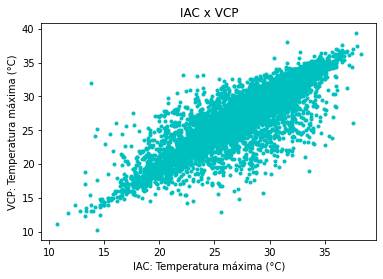

In [ ]:
plt.plot(df_IAC['N_AIRTMP_MAX'],df_VCP['N_AIRTMP_MAX'],'c.')
plt.xlabel('IAC: Temperatura máxima (°C)')
plt.ylabel('VCP: Temperatura máxima (°C)')
plt.title('IAC x VCP')

### Mininum temperatures

Text(0.5, 1.0, 'IAC x VCP')

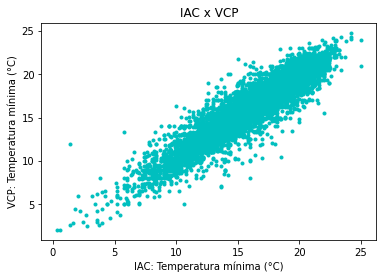

In [ ]:
plt.plot(df_IAC['N_AIRTMP_MIN'],df_VCP['N_AIRTMP_MIN'],'c.')
plt.xlabel('IAC: Temperatura mínima (°C)')
plt.ylabel('VCP: Temperatura mínima (°C)')
plt.title('IAC x VCP')

## **Linear Regression**


### Maximum Temperatures

In [ ]:
#transforming columns into vector
x = df_IAC['N_AIRTMP_MAX'].values.reshape(-1,1) 
y = df_VCP['N_AIRTMP_MAX'].values.reshape(-1,1)

x

array([[28.8],
       [29.4],
       [29.6],
       ...,
       [31.7],
       [32.1],
       [33.5]])

In [ ]:
#filling missing data
imputer = SimpleImputer()
x_imputed = imputer.fit_transform(x)
y_imputed = imputer.fit_transform(y)

In [ ]:
#renaming varibles
x_train = x_imputed
y_train = y_imputed

#performing regression
regressor_max = LinearRegression()  
regressor_max.fit(x_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [ ]:
#obtaining intercept and slope - relationship between Tmax_IAC and Tmax_VCP
print("Tmax_VCP = Tmax_IAC x",regressor_max.coef_,"+",regressor_max.intercept_)

Tmax_VCP = Tmax_IAC x [[0.90029361]] + [2.3624788]


### Minimum Temperatures

In [ ]:
#transforming columns into vector
X = df_IAC['N_AIRTMP_MIN'].values.reshape(-1,1)
Y = df_VCP['N_AIRTMP_MIN'].values.reshape(-1,1)

X

array([[17.5],
       [17.2],
       [17.8],
       ...,
       [18.7],
       [19.8],
       [19. ]])

In [ ]:
#filling missing data
imputer = SimpleImputer()
X_imputed = imputer.fit_transform(X)
Y_imputed = imputer.fit_transform(Y)

In [ ]:
#renaming variables
X_train = X_imputed
Y_train = Y_imputed

#performing linear regression Tmin
regressor_min = LinearRegression()  
regressor_min.fit(X_train, Y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [ ]:
#obtaining intercept and slope - relationship between Tmin_IAC and Tmin_VCP
print("Tmin_VCP = Tmin_IAC x",regressor_min.coef_,"+",regressor_min.intercept_)

Tmin_VCP = Tmin_IAC x [[0.91160679]] + [1.60786807]


## **Using linear regression and IAC data (1961-1990) to estimate VCP climatic normal**

### Maximum temperatures

In [ ]:
#defining predictor IAC climatic normal
Z = IAC_climaticNormal['N_AIRTMP_MAX'].values.reshape(-1,1) 

In [ ]:
#filling missing data
Z_imputed = imputer.fit_transform(Z)

In [ ]:
#predicting Tmax_VCP using regression
tmax_pred=regressor_max.predict(Z_imputed)

tmax_pred

array([[27.48067066],
       [25.77011279],
       [30.63169831],
       ...,
       [24.50970173],
       [25.77011279],
       [28.29093491]])

#### Plot Tmax IAC vs. VCP

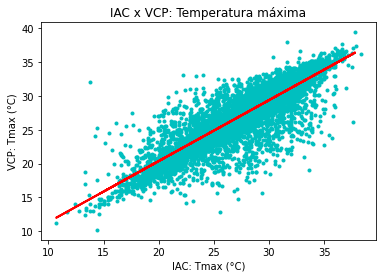

In [ ]:
plt.plot(df_IAC['N_AIRTMP_MAX'],df_VCP['N_AIRTMP_MAX'],'c.')
plt.plot(Z, tmax_pred, color='red', linewidth=2)
plt.xlabel('IAC: Tmax (°C)')
plt.ylabel('VCP: Tmax (°C)')
plt.title('IAC x VCP: Temperatura máxima')
plt.show()

### Minimum temperatures

In [ ]:
#defining predictor IAC climatic normal
W = IAC_climaticNormal['N_AIRTMP_MIN'].values.reshape(-1,1) 

In [ ]:
#filling missing data
W_imputed = imputer.fit_transform(W)

In [ ]:
#predicting tmin from VCP using regression
tmin_pred=regressor_min.predict(W_imputed)

tmin_pred

array([[18.92839708],
       [19.01955776],
       [18.92839708],
       ...,
       [18.19911165],
       [11.81786412],
       [15.09964856]])

#### Plot Tmin IAC vs. VCP

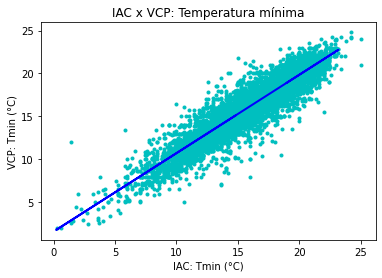

In [ ]:
plt.plot(df_IAC['N_AIRTMP_MIN'],df_VCP['N_AIRTMP_MIN'],'c.')
plt.plot(W, tmin_pred, color='blue', linewidth=2)
plt.xlabel('IAC: Tmin (°C)')
plt.ylabel('VCP: Tmin (°C)')
plt.title('IAC x VCP: Temperatura mínima')
plt.show()

### Constructing VCP climatological normal dataframe


In [ ]:
#Tmax dataframe
tmax = pd.DataFrame(data=tmax_pred, columns=['N_AIRTMP_MAX'])
tmax.head()

,N_AIRTMP_MAX
0,27.480671
1,25.770113
2,30.631698
3,27.480671
4,30.001493


In [ ]:
#Tmin dataframe
tmin = pd.DataFrame(data=tmin_pred, columns=['N_AIRTMP_MIN'])
tmin.head()

,N_AIRTMP_MIN
0,18.928397
1,19.019558
2,18.928397
3,19.840004
4,18.654915


In [ ]:
date = IAC_climaticNormal['DATE'] #using column DATE as index

#concatenating tmax and tmin dataframes
VCP_climaticNormal = pd.concat([date, tmax], axis=1)
VCP_climaticNormal = pd.concat([VCP_climaticNormal,tmin],axis=1)
VCP_climaticNormal

,DATE,N_AIRTMP_MAX,N_AIRTMP_MIN
0,1961-01-01,27.480671,18.928397
1,1961-01-02,25.770113,19.019558
2,1961-01-03,30.631698,18.928397
3,1961-01-04,27.480671,19.840004
4,1961-01-05,30.001493,18.654915
...,...,...,...
10945,1990-12-27,29.191229,18.381433
10946,1990-12-28,30.451640,17.105184
10947,1990-12-29,24.509702,18.199112
10948,1990-12-30,25.770113,11.817864


In [ ]:
del VCP_climaticNormal
del result

In [ ]:
#saving VCP climatic normal locally
VCP_climaticNormal.to_csv('VCP_nc_6190.csv')

## **Computing Heatwaves for VCP weather station**

Function: *tex.check_HeatWave* from climatex library

In [ ]:
#VCP_climaticNormal
VCP_climaticNormal.head()

,DATE,N_AIRTMP_MAX,N_AIRTMP_MIN
0,1961-01-01,27.480671,18.928397
1,1961-01-02,25.770113,19.019558
2,1961-01-03,30.631698,18.928397
3,1961-01-04,27.480671,19.840004
4,1961-01-05,30.001493,18.654915


In [ ]:
#VCP database
databaseVCP = df_VCP.copy()

In [ ]:
#checking function parameters
help(tex.check_HeatWave)

Help on function check_HeatWave in module climatex:

check_HeatWave(database, db_columnMAX, db_columnMIN, climatic_normal, pct_columnMAX, pct_columnMIN, db_columnDay365=False, db_complete=False, cn_columnDay365=False, df_pct=None, percentile_value=0.9, window_size=15)
    #-------------------------------------------------------------------------------
    ## Checks for Heat Waves on the database according to the Climatic Normal This
    ## function uses Geirinhas et al. 2018 method. It obtains first a dataframe with
    ## the percentiles computed from the Climatic Normal according to the defined
    ## window size (df_pct). Then compares it with the database, to check if the
    ## maximum and minimum temperatures are above the corresponding percentile. If
    ## the temperatures are above the threshold, the column 'above_pct' receives 1.
    ## This column is then used to identify if there are 3 or more consecutive
    ## extremely warm days (Heat Wave). The column 'HW' then receives

In [ ]:
pd.options.mode.chained_assignment = None # disables SettingWithCopyWarning
#computing heatwaves and percentiles threshold
HW_VCP,pct_VCP = tex.check_HeatWave(databaseVCP,'N_AIRTMP_MAX','N_AIRTMP_MIN',
                           VCP_climaticNormal,'N_AIRTMP_MAX','N_AIRTMP_MIN')

In [ ]:
#percentiles threshold
pct_VCP

,CTX90pct,CTN90pct
DAY365,,
1,30.631698,20.022325
2,30.721728,20.113486
3,30.811757,20.204647
4,30.901786,20.204647
5,30.991816,20.204647
...,...,...
361,30.451640,20.022325
362,30.451640,19.931165
363,30.361610,19.931165


In [ ]:
#heatwaves dataframe
HW_VCP

,DAY365,DATE,N_AIRTMP_MAX,N_AIRTMP_MIN,above_pct,HW
0,1,1983-01-01,30.0,18.0,0,0
1,2,1983-01-02,29.3,18.0,0,0
2,3,1983-01-03,30.6,18.6,0,0
3,4,1983-01-04,30.5,19.0,0,0
4,5,1983-01-05,22.0,19.4,0,0
...,...,...,...,...,...,...
13135,361,2018-12-27,31.2,18.4,0,0
13136,362,2018-12-28,31.5,18.9,0,0
13137,363,2018-12-29,32.1,18.7,0,0
13138,364,2018-12-30,33.6,19.4,0,0


In [ ]:
#checking dates with heatwaves (HW = 1)
HW_VCP[HW_VCP['HW']==1]

,DAY365,DATE,N_AIRTMP_MAX,N_AIRTMP_MIN,above_pct,HW
51,52,1983-02-21,32.6,20.8,1,1
52,53,1983-02-22,33.6,21.5,1,1
53,54,1983-02-23,31.8,20.5,1,1
54,55,1983-02-24,32.8,20.6,1,1
55,56,1983-02-25,33.0,21.0,1,1
...,...,...,...,...,...,...
13126,352,2018-12-18,32.5,21.9,1,1
13127,353,2018-12-19,31.4,22.1,1,1
13128,354,2018-12-20,33.5,22.7,1,1
13129,355,2018-12-21,33.3,23.3,1,1


## **Metrics**

Using functions **tex.wave_metrics** and **tex.wave_seasonMetrics** from climatex library to obtain yearly and seasonal metrics

### Yearly metrics

Function: *tex.wave_metrics*

In [ ]:
#checking wave_metrics parameters
help(tex.wave_metrics)

Help on function wave_metrics in module climatex:

wave_metrics(df_checkW, wave_column, plot=False)
    #-------------------------------------------------------------------------------
    ## Function to obtain the yearly metrics of a Heat/Cold Wave given the database
    ## dataframe containing the 'HW'/'CW' column that indicates if a day is inside
    ## of a Heat/Cold Wave or not (check get_wave function). This function obtains
    ## the number of HW/CW events (HWN/CWN), the event with maximum duration
    ## (HWD/CWD) and the cumulative sum of wave durations (HWF) for each year of the
    ## dataframe. These metrics are stored in a dataframe which includes the
    ## Heat/Cold Wave metrics for each year of the database.
    ##
    ## It is possible to plot the metrics (plot=True). For a better adjustment of
    ## the plots, check function plot_oneMetric
    ##
    ## :param      df_checkW:    Database dataframe with the column "HW" or CW"
    ## :type       df_checkW:    pandas.D

In [ ]:
#obtaining yearly metrics
HW_VCP_metrics = tex.wave_metrics(HW_VCP,'HW')
HW_VCP_metrics

,HWN,HWD,HWF
YEAR,,,
1983,3.0,5.0,12.0
1984,7.0,6.0,28.0
1985,4.0,4.0,13.0
1986,2.0,7.0,10.0
1987,4.0,8.0,18.0
1988,5.0,9.0,22.0
1989,0.0,0.0,0.0
1990,6.0,6.0,22.0
1991,0.0,0.0,0.0


### Seasonal metrics

Function: *tex.wave_seasonMetrics*

In [ ]:
#checking wave_seasonMetrics parameters
help(tex.wave_seasonMetrics)

Help on function wave_seasonMetrics in module climatex:

wave_seasonMetrics(df_checkW, wave_column, plot=False)
    #-------------------------------------------------------------------------------
    ## Function to obtain the seasonal metrics of a Heat/Cold Wave given the
    ## database dataframe containing the 'HW'/'CW' column that indicates if a day is
    ## part of a Heat/Cold Wave or not (check get_wave function). This function
    ## obtains the number of HW/CW events (HWN/CWN), the event with maximum duration
    ## (HWD/CWD) and the cumulative sum of wave durations (HWF) for all seasons
    ## (summer, autumn, winter and spring) of each year of the dataframe. These
    ## metrics are stored in a dataframe which includes the Heat/Cold Wave metrics
    ## for each year of the database, separated by seasons.
    ##
    ## The calendar year adopted is from december of previous year until november of
    ## actual year.
    ##
    ## It is possible to plot the seasonal metrics, fo

In [ ]:
#obtaining seasonal metrics
HW_VCP_seasonMetrics = tex.wave_seasonMetrics(HW_VCP,'HW')
HW_VCP_seasonMetrics

HWN  HWD   HWF
YEAR SEASON                
1983 1       1.0  5.0   5.0
     2       1.0  4.0   4.0
     3       1.0  3.0   3.0
     4       0.0  0.0   0.0
1984 1       4.0  6.0  18.0
...          ...  ...   ...
2017 4       1.0  5.0   5.0
2018 1       1.0  3.0   3.0
     2       2.0  5.0   8.0
     3       1.0  3.0   3.0
     4       0.0  0.0   0.0

[144 rows x 3 columns]

## **Comparing VCP with IAC**


### Checking coincident heatwave days

In [ ]:
# IAC heatwaves dataframe
HW_IAC = df_IAC.copy()

In [ ]:
#only heatwaves dataframe IAC
onlyHW_IAC = HW_IAC[HW_IAC['HW']==1]
onlyHW_IAC.head()

,DATE,DAY365,YEAR,N_RAIN_TOT,N_AIRTMP_MAX,N_AIRTMP_MIN,above_pct,HW
188,1983-07-08,189.0,1983.0,0.0,28.4,15.5,1.0,1.0
189,1983-07-09,190.0,1983.0,0.0,28.9,16.0,1.0,1.0
190,1983-07-10,191.0,1983.0,0.0,29.8,15.2,1.0,1.0
550,1984-07-04,185.0,1984.0,0.3,27.9,16.2,1.0,1.0
551,1984-07-05,186.0,1984.0,0.0,29.6,15.4,1.0,1.0


In [ ]:
#only heatwaves dataframe VCP
onlyHW_VCP = HW_VCP[HW_VCP['HW']==1]
onlyHW_VCP.head()

,DAY365,DATE,N_AIRTMP_MAX,N_AIRTMP_MIN,above_pct,HW
51,52,1983-02-21,32.6,20.8,1,1
52,53,1983-02-22,33.6,21.5,1,1
53,54,1983-02-23,31.8,20.5,1,1
54,55,1983-02-24,32.8,20.6,1,1
55,56,1983-02-25,33.0,21.0,1,1


In [ ]:
#selecting only DATE and HW columns
onlyHW_IAC = onlyHW_IAC[['DATE','HW']]
onlyHW_VCP = onlyHW_VCP[['DATE','HW']]

In [ ]:
#checking number of days with heatwaves IAC
onlyHW_IAC.shape

(346, 2)

In [ ]:
#checking number of days with heatwaves VCP
onlyHW_VCP.shape

(596, 2)

In [ ]:
#merging IAC and VCP
IAC_VCP = pd.merge(onlyHW_IAC,onlyHW_VCP)

IAC_VCP

,DATE,HW
0,1983-07-08,1.0
1,1983-07-09,1.0
2,1983-07-10,1.0
3,1984-07-04,1.0
4,1984-07-05,1.0
...,...,...
225,2018-12-18,1.0
226,2018-12-19,1.0
227,2018-12-20,1.0
228,2018-12-21,1.0


In [ ]:
#checking coincident heatwave days
IAC_VCP.shape

(230, 2)

### Plot Out 2014 - Fev 2015

#### Reading Percentiles

##### IAC

In [ ]:
#loading IAC percentiles data
gl = drive.CreateFile({'id':'1jWCu_Hxqe1RecH2SWCZ7VDy-NRHp-lg1'})
gl.GetContentFile('IAC_pct1956_2018.csv')

In [ ]:
#reading file with percentiles IAC
pct_IAC = pd.read_csv('/content/IAC_pct1956_2018.csv')
pct_IAC.head()


,DAY365,CTX90pct,CTN90pct
0,1,31.40,20.2
1,2,31.53,20.3
2,3,31.60,20.4
3,4,31.78,20.4
4,5,31.80,20.4


##### VCP

In [ ]:
#reading file with percentiles VCP
pct_VCP

,CTX90pct,CTN90pct
DAY365,,
1,30.631698,20.022325
2,30.721728,20.113486
3,30.811757,20.204647
4,30.901786,20.204647
5,30.991816,20.204647
...,...,...
361,30.451640,20.022325
362,30.451640,19.931165
363,30.361610,19.931165


#### Selecting data: from 01-10-2014 to 31-01-2015

In [ ]:
#defining dates from 01-10-2014 to 31-01-2015
start_date = '2014-10-01'
end_date = '2015-01-31'

In [ ]:
#IAC
sel_dataIAC = HW_IAC[(HW_IAC['DATE']>=start_date)&(HW_IAC['DATE']<=end_date)]
merge_IAC = pd.merge(sel_dataIAC, pct_IAC, on='DAY365')
merge_IAC = merge_IAC.sort_values(by='DATE')
merge_IAC.head()

,DATE,DAY365,YEAR,N_RAIN_TOT,N_AIRTMP_MAX,N_AIRTMP_MIN,above_pct,HW,CTX90pct,CTN90pct
0,2014-10-01,274.0,2014.0,1.3,32.3,19.9,0.0,0.0,32.80,18.40
1,2014-10-02,275.0,2014.0,0.8,30.1,18.2,0.0,0.0,32.72,18.40
2,2014-10-03,276.0,2014.0,0.0,24.4,13.6,0.0,0.0,32.62,18.50
3,2014-10-04,277.0,2014.0,0.0,24.1,12.3,0.0,0.0,32.60,18.50
4,2014-10-05,278.0,2014.0,0.0,22.7,11.6,0.0,0.0,32.60,18.41


In [ ]:
#VCP
sel_dataVCP = HW_VCP[(HW_VCP['DATE']>=start_date)&(HW_VCP['DATE']<=end_date)]
merge_VCP = pd.merge(sel_dataVCP, pct_VCP, on='DAY365')
merge_VCP = merge_VCP.sort_values(by='DATE')
merge_VCP.head()

,DAY365,DATE,N_AIRTMP_MAX,N_AIRTMP_MIN,above_pct,HW,CTX90pct,CTN90pct
0,274,2014-10-01,28.3,20.2,0,0,31.811083,18.381433
1,275,2014-10-02,23.3,15.2,0,0,31.712051,18.381433
2,276,2014-10-03,23.0,13.7,0,0,31.712051,18.472594
3,277,2014-10-04,21.9,12.0,0,0,31.712051,18.472594
4,278,2014-10-05,23.8,11.4,0,0,31.712051,18.390549


#### Plot temperature and percentiles for both weather stations

> CTX90pct and N_AIRTMP_MAX

> CTN90pct and N_AIRTMP_MIN


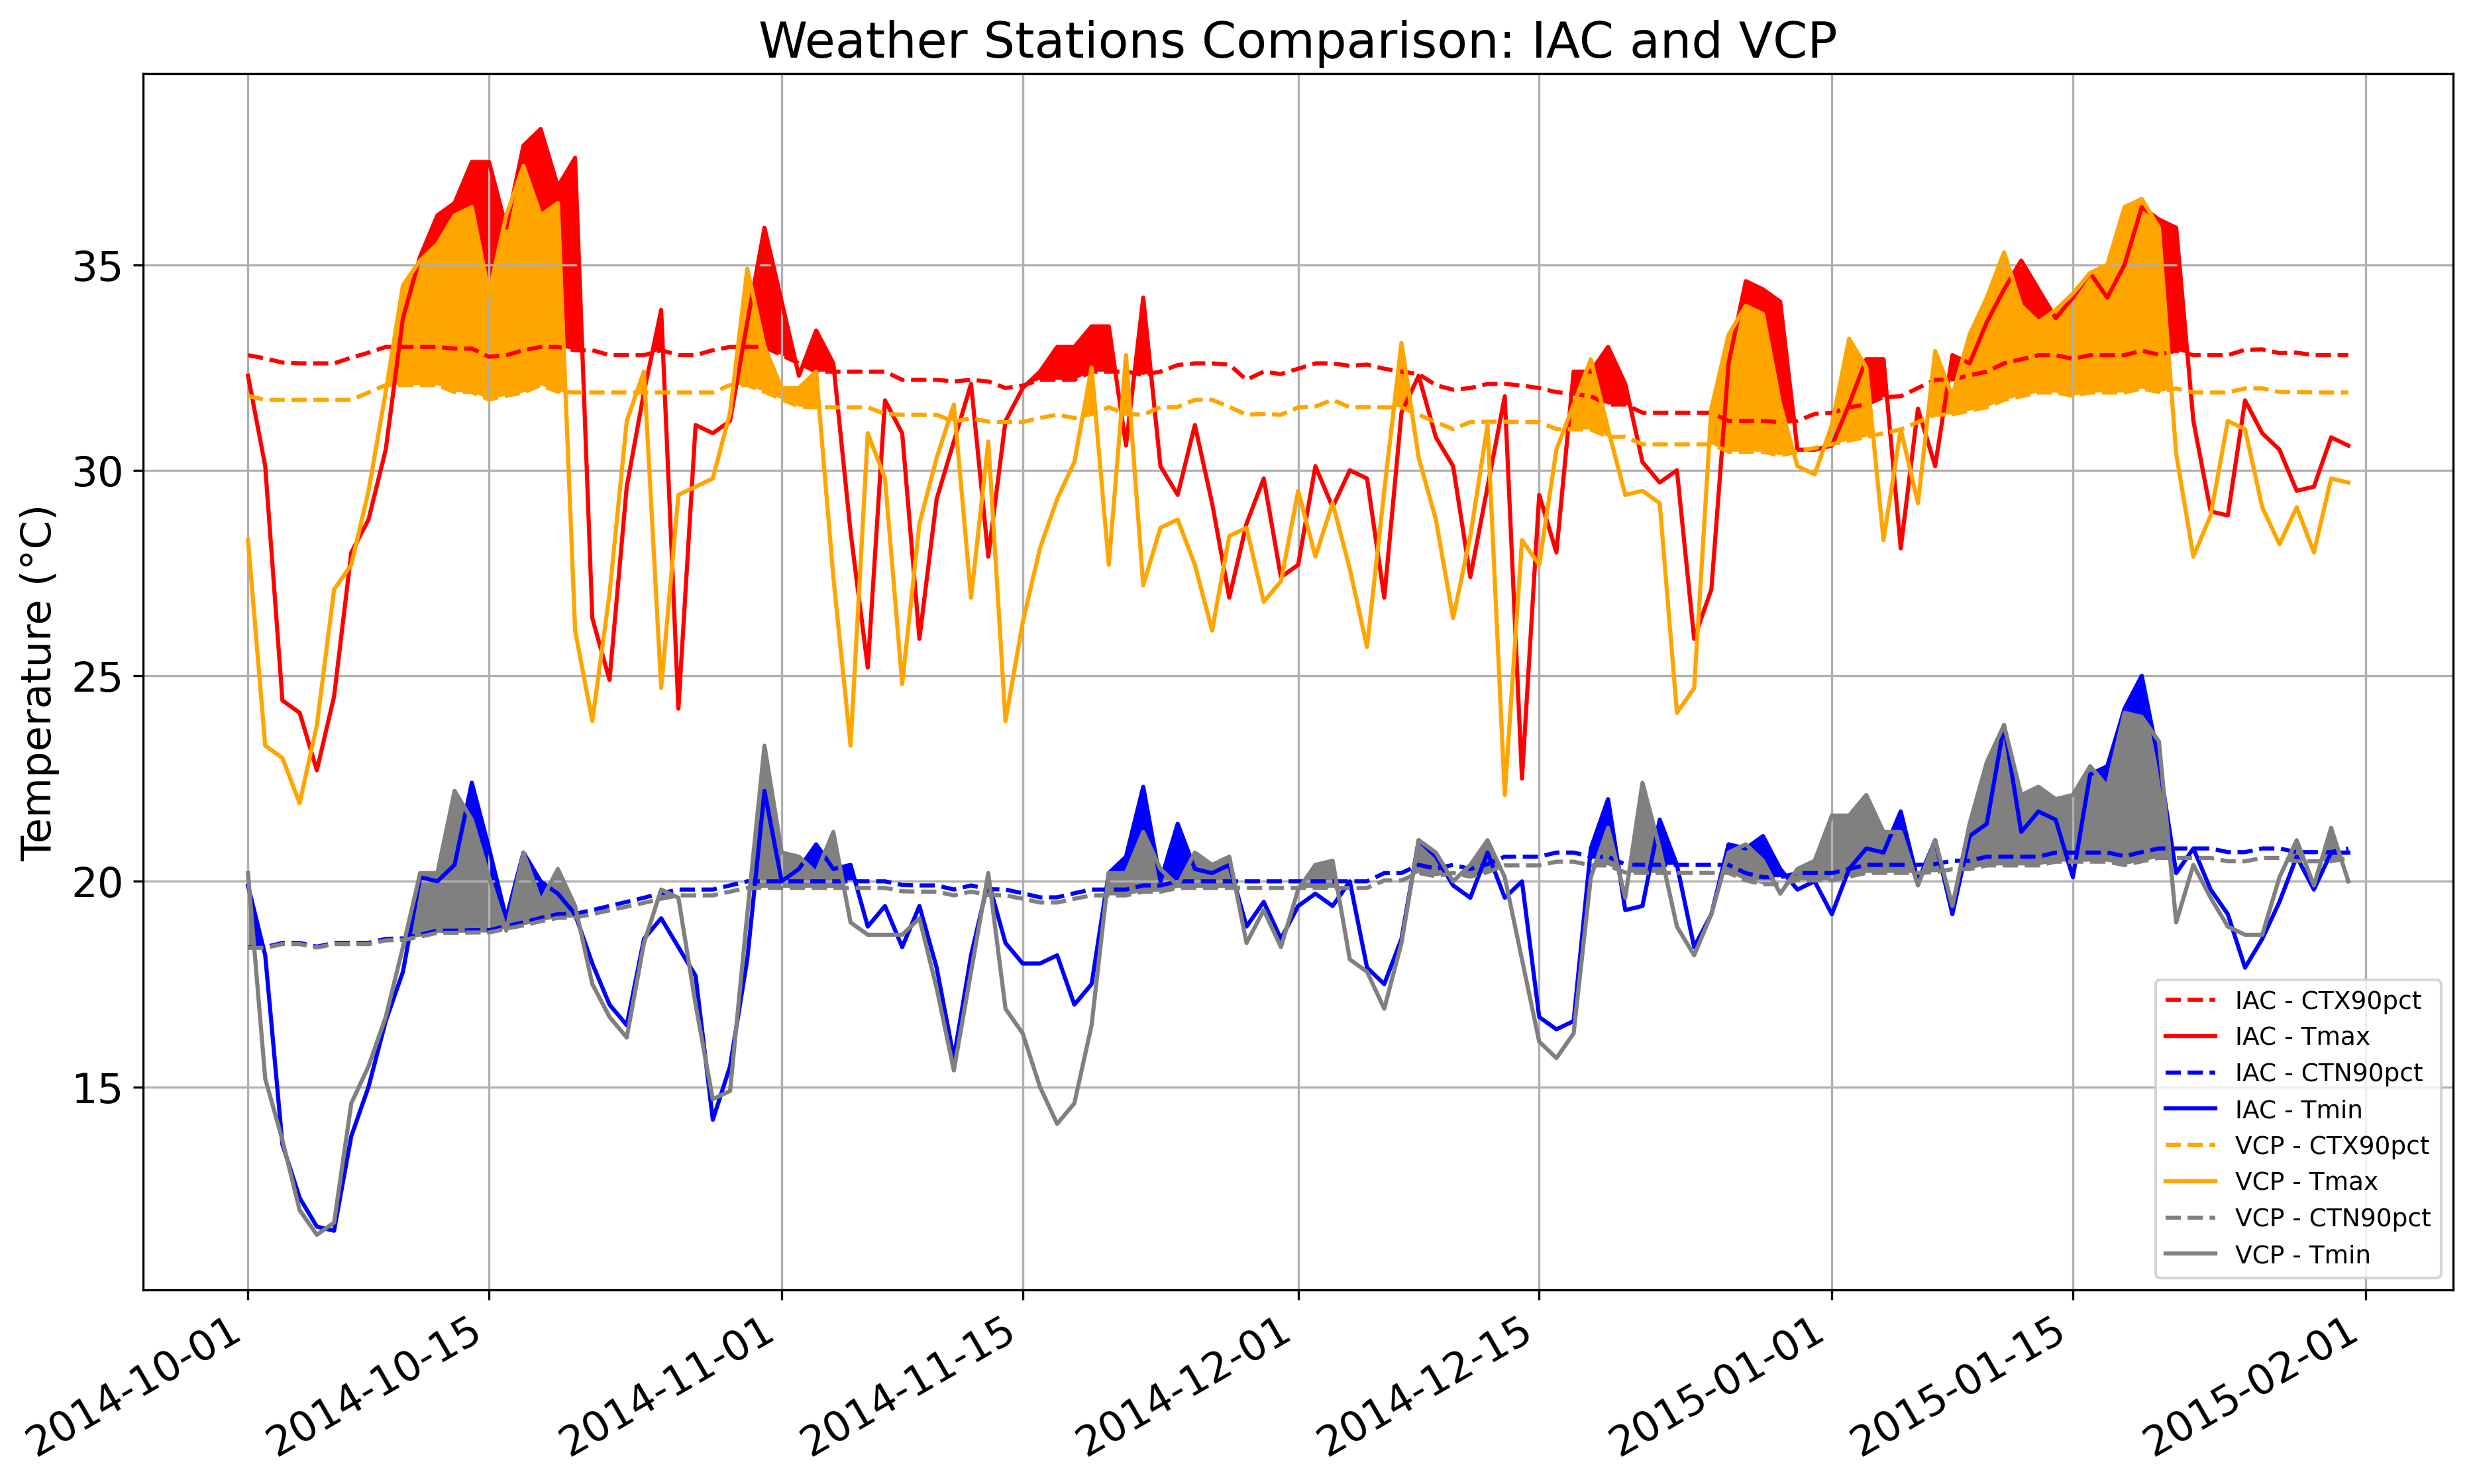

In [ ]:
#CTX90pct N_AIRTMP_MAX
plt.figure(figsize=(15,9),dpi=300)
plt.plot(merge_IAC['DATE'], merge_IAC['CTX90pct'],'--r',label='IAC - CTX90pct')
plt.plot(merge_IAC['DATE'], merge_IAC['N_AIRTMP_MAX'],'r',label='IAC - Tmax')
plt.fill_between(merge_IAC['DATE'], merge_IAC['CTX90pct'], merge_IAC['N_AIRTMP_MAX'], where = merge_IAC['CTX90pct'] <= merge_IAC['N_AIRTMP_MAX'], facecolor='red', interpolate=True)

#CTN90pct N_AIRTMP_MIN
plt.plot(merge_IAC['DATE'], merge_IAC['CTN90pct'],'--b',label='IAC - CTN90pct')
plt.plot(merge_IAC['DATE'], merge_IAC['N_AIRTMP_MIN'],'b',label='IAC - Tmin')
plt.fill_between(merge_IAC['DATE'], merge_IAC['CTN90pct'], merge_IAC['N_AIRTMP_MIN'], where = merge_IAC['CTN90pct'] <= merge_IAC['N_AIRTMP_MIN'], facecolor='blue', interpolate=True)

#CTX90pct N_AIRTMP_MAX
plt.plot(merge_VCP['DATE'], merge_VCP['CTX90pct'],'--',color='orange',label='VCP - CTX90pct')
plt.plot(merge_VCP['DATE'], merge_VCP['N_AIRTMP_MAX'],color='orange',label='VCP - Tmax')
plt.fill_between(merge_VCP['DATE'], merge_VCP['CTX90pct'], merge_VCP['N_AIRTMP_MAX'], where = merge_VCP['CTX90pct'] <= merge_VCP['N_AIRTMP_MAX'], facecolor='orange', interpolate=True)

#CTN90pct N_AIRTMP_MIN
plt.plot(merge_VCP['DATE'], merge_VCP['CTN90pct'],'--',color ='gray',label='VCP - CTN90pct')
plt.plot(merge_VCP['DATE'], merge_VCP['N_AIRTMP_MIN'],color='gray',label='VCP - Tmin')
plt.fill_between(merge_VCP['DATE'], merge_VCP['CTN90pct'], merge_VCP['N_AIRTMP_MIN'], where = merge_VCP['CTN90pct'] <= merge_VCP['N_AIRTMP_MIN'], facecolor='gray', interpolate=True)

plt.title('Weather Stations Comparison: IAC and VCP',fontsize=18)
plt.ylabel('Temperature (°C)',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

fig = plt.gcf()
fig.autofmt_xdate()
plt.grid()
plt.legend(loc=4, prop={'size': 9})
plt.show()

## **Acknowledgements**


This work belongs to the project ‘Human health and adaptation to climate change in Brazil: a data science approach’ funded by FAPESP (São Paulo Research Foundation) 17/20013-0.

**Contributors:** Dr. Gabriel Blain, Felipe Pedroso and Lucas Ueda